In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 741
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  HS78Q8CD_05_16_22
NN-MODEL FILENAME:  ./models/HS78Q8CD_05_16_22_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 6
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  6


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 71312.90 MiB, increment: 65310.92 MiB
Quantization TIME:  0.59 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15556
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 64
TOTAL SERIAL TIMESTEPS:   15556
TOTAL PARALLEL TIMESTEPS: 64


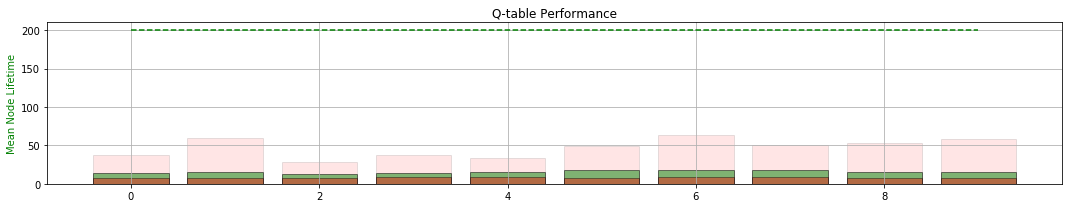

MEMORY COUNTER:  15556
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 598.131	LOSS : 568.677	LOSS : 560.100	LOSS : 523.849	LOSS : 529.972	LOSS : 506.441	LOSS : 514.059	LOSS : 523.089	LOSS : 532.373	LOSS : 522.807	LOSS : 507.839	LOSS : 521.260	LOSS : 518.517	LOSS : 513.427	LOSS : 503.333	LOSS : 476.490	LOSS : 473.897	LOSS : 482.831	LOSS : 473.265	LOSS : 475.954	
Validating... MEAN TIME:  99.565
LOSS : 480.946	LOSS : 474.164	LOSS : 461.214	LOSS : 460.215	LOSS : 451.450	LOSS : 460.626	LOSS : 466.761	LOSS : 471.145	LOSS : 472.579	LOSS : 462.162	LOSS : 466.492	LOSS : 466.862	LOSS : 464.700	LOSS : 469.649	LOSS : 473.981	LOSS : 465.830	LOSS : 452.154	LOSS : 451.566	LOSS : 477.399	LOSS : 468.267	
Validating... MEAN TIME:  120.185
LOSS : 462.894	LOSS : 473.480	LOSS : 454.736	LOSS : 469.513	LOSS : 451.782	LOSS : 473.059	LOSS : 478.278	LOSS : 469.516	LOSS : 481.184	LOSS : 478.434	LOSS : 479.799	LOSS : 488.589	LOSS : 485.792	LOSS : 495.134	LOSS : 487.912	LOSS : 493.303	LOSS : 48

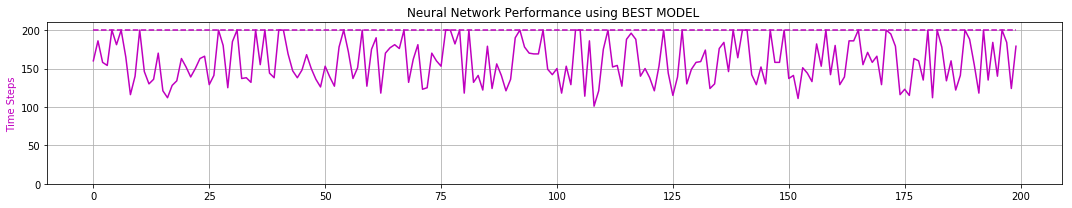

peak memory: 72786.55 MiB, increment: 65577.64 MiB
0 -max- [ 0.176  1.522  0.209  2.636  0.275]
0 -min- [-0.292 -1.779 -0.203 -2.462  0.225]

1 -max- [ 0.229  2.169  0.209  2.769  0.325]
1 -min- [-0.440 -1.782 -0.207 -3.000  0.275]

2 -max- [ 0.194  1.971  0.209  2.674  0.374]
2 -min- [-0.224 -1.724 -0.209 -2.967  0.326]

3 -max- [ 0.205  1.796  0.209  2.690  0.425]
3 -min- [-0.339 -2.437 -0.206 -2.723  0.375]

4 -max- [ 0.274  2.349  0.209  2.288  0.475]
4 -min- [-0.256 -1.566 -0.209 -3.041  0.426]

5 -max- [ 0.426  2.654  0.209  2.303  0.525]
5 -min- [-0.271 -1.707 -0.209 -3.322  0.476]

6 -max- [ 0.680  2.840  0.209  2.210  0.575]
6 -min- [-0.403 -1.392 -0.209 -3.227  0.525]

7 -max- [ 0.341  2.475  0.209  2.751  0.624]
7 -min- [-0.192 -1.711 -0.209 -3.127  0.575]

8 -max- [ 0.228  2.128  0.208  2.320  0.675]
8 -min- [-0.287 -1.543 -0.209 -3.029  0.626]

9 -max- [ 0.268  1.908  0.209  1.382  0.724]
9 -min- [-0.112 -1.004 -0.209 -2.814  0.677]

Quantization TIME:  0.58 minutes


ITER

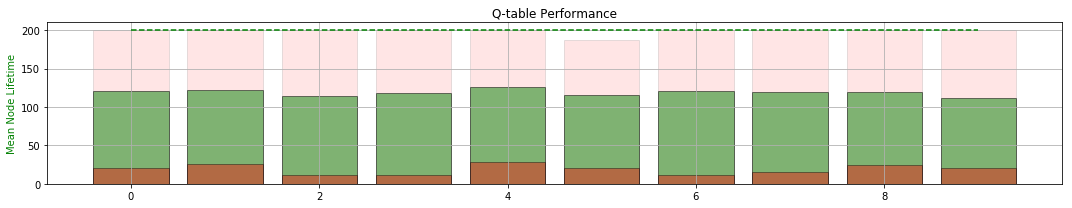

MEMORY COUNTER:  134274
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 284.879	LOSS : 269.974	LOSS : 268.034	LOSS : 238.688	LOSS : 239.371	LOSS : 223.702	LOSS : 220.228	LOSS : 211.497	LOSS : 212.868	LOSS : 200.570	LOSS : 208.224	LOSS : 194.255	LOSS : 184.314	LOSS : 186.947	LOSS : 205.349	LOSS : 179.387	LOSS : 190.355	LOSS : 175.316	LOSS : 170.968	LOSS : 173.410	
Validating... MEAN TIME:  163.24
LOSS : 181.626	LOSS : 163.777	LOSS : 157.836	LOSS : 167.351	LOSS : 166.382	LOSS : 175.897	LOSS : 150.684	LOSS : 161.457	LOSS : 168.266	LOSS : 159.552	LOSS : 152.677	LOSS : 152.190	LOSS : 158.273	LOSS : 149.055	LOSS : 156.076	LOSS : 154.197	LOSS : 148.429	LOSS : 139.916	LOSS : 152.295	LOSS : 150.590	
Validating... MEAN TIME:  179.425
LOSS : 152.678	LOSS : 143.224	LOSS : 157.520	LOSS : 157.869	LOSS : 158.463	LOSS : 157.476	LOSS : 145.448	LOSS : 135.180	LOSS : 132.482	LOSS : 160.072	LOSS : 154.569	LOSS : 148.729	LOSS : 149.373	LOSS : 152.448	LOSS : 161.100	LOSS : 149.326	LOSS : 1

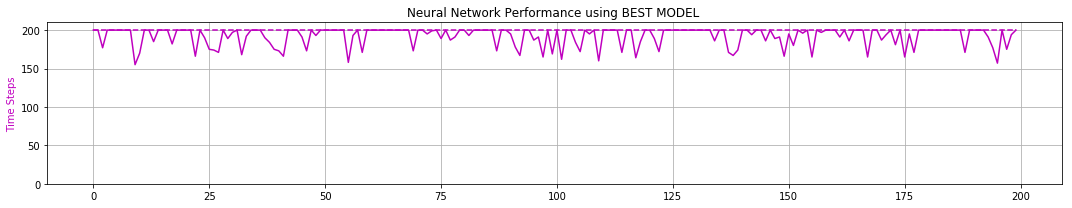

peak memory: 74049.28 MiB, increment: 65623.61 MiB
0 -max- [ 1.055  1.918  0.209  2.221  0.275]
0 -min- [-1.224 -2.030 -0.209 -2.135  0.226]

1 -max- [ 1.104  1.733  0.208  2.034  0.325]
1 -min- [-1.150 -2.426 -0.209 -2.288  0.275]

2 -max- [ 1.040  1.906  0.209  2.344  0.374]
2 -min- [-1.363 -2.260 -0.208 -2.068  0.325]

3 -max- [ 1.090  1.750  0.209  1.885  0.425]
3 -min- [-1.124 -1.895 -0.209 -2.176  0.375]

4 -max- [ 1.300  1.984  0.209  2.316  0.475]
4 -min- [-1.346 -2.255 -0.209 -1.915  0.425]

5 -max- [ 1.075  1.834  0.209  2.056  0.525]
5 -min- [-1.266 -1.851 -0.209 -2.282  0.476]

6 -max- [ 1.108  1.915  0.209  2.181  0.575]
6 -min- [-1.120 -2.204 -0.209 -2.580  0.525]

7 -max- [ 1.219  2.063  0.208  2.300  0.625]
7 -min- [-1.170 -2.006 -0.209 -2.522  0.576]

8 -max- [ 1.028  1.744  0.209  2.093  0.674]
8 -min- [-1.241 -2.088 -0.209 -2.282  0.625]

9 -max- [ 1.244  1.885  0.209  2.945  0.724]
9 -min- [-1.132 -2.318 -0.209 -2.278  0.676]

Quantization TIME:  0.59 minutes


ITER

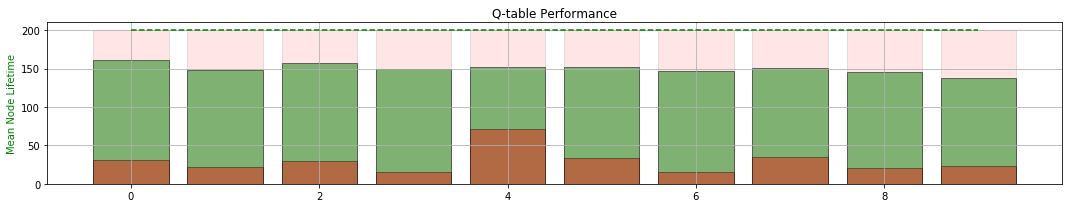

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 77.692	LOSS : 79.899	LOSS : 71.403	LOSS : 69.173	LOSS : 69.936	LOSS : 74.291	LOSS : 71.155	LOSS : 69.486	LOSS : 72.389	LOSS : 62.933	LOSS : 65.381	LOSS : 63.531	LOSS : 65.029	LOSS : 63.693	LOSS : 69.255	LOSS : 72.199	LOSS : 74.779	LOSS : 69.939	LOSS : 70.076	LOSS : 65.055	
Validating... MEAN TIME:  187.385
LOSS : 67.592	LOSS : 62.140	LOSS : 64.824	LOSS : 72.222	LOSS : 71.345	LOSS : 73.103	LOSS : 65.764	LOSS : 70.975	LOSS : 61.400	LOSS : 66.864	LOSS : 63.665	LOSS : 71.022	LOSS : 68.135	LOSS : 65.424	LOSS : 64.878	LOSS : 73.048	LOSS : 67.303	LOSS : 71.568	LOSS : 68.213	LOSS : 62.825	
Validating... MEAN TIME:  195.03
LOSS : 65.247	LOSS : 67.108	LOSS : 70.070	LOSS : 62.846	LOSS : 58.364	LOSS : 62.722	LOSS : 64.151	LOSS : 65.557	LOSS : 65.260	LOSS : 60.963	LOSS : 63.634	LOSS : 65.940	LOSS : 64.614	LOSS : 63.440	LOSS : 61.143	LOSS : 68.967	LOSS : 63.287	LOSS : 67.719	LOSS : 62.600	LOSS : 62.937	
Validat

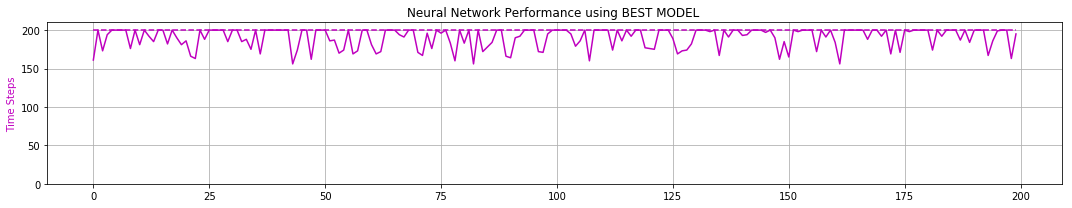

peak memory: 74005.30 MiB, increment: 65530.97 MiB
0 -max- [ 2.127  2.162  0.209  1.710  0.275]
0 -min- [-2.134 -2.570 -0.209 -1.786  0.225]

1 -max- [ 2.391  2.628  0.208  1.815  0.325]
1 -min- [-2.048 -2.573 -0.209 -1.951  0.275]

2 -max- [ 1.793  1.873  0.206  1.786  0.374]
2 -min- [-1.978 -2.404 -0.209 -1.915  0.325]

3 -max- [ 2.210  2.359  0.207  1.675  0.425]
3 -min- [-2.039 -2.378 -0.209 -1.920  0.376]

4 -max- [ 1.766  2.058  0.208  1.669  0.475]
4 -min- [-2.033 -2.423 -0.209 -2.113  0.425]

5 -max- [ 1.903  2.197  0.207  1.926  0.525]
5 -min- [-2.292 -2.540 -0.209 -2.023  0.476]

6 -max- [ 1.887  2.052  0.208  1.594  0.575]
6 -min- [-2.034 -2.405 -0.209 -1.701  0.525]

7 -max- [ 1.958  2.237  0.209  2.175  0.625]
7 -min- [-1.879 -2.199 -0.209 -1.646  0.575]

8 -max- [ 0.881  1.554  0.206  1.933  0.674]
8 -min- [-2.090 -2.563 -0.209 -2.019  0.625]

9 -max- [ 1.884  2.231  0.209  1.949  0.725]
9 -min- [-1.927 -2.383 -0.209 -2.325  0.676]

Quantization TIME:  0.58 minutes


ITER

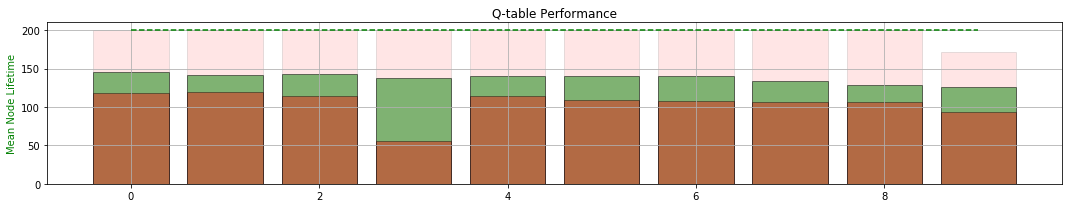

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 63.328	LOSS : 68.660	LOSS : 66.458	LOSS : 68.390	LOSS : 56.109	LOSS : 63.823	LOSS : 64.551	LOSS : 63.629	LOSS : 61.068	LOSS : 60.751	LOSS : 62.587	LOSS : 59.973	LOSS : 64.948	LOSS : 59.331	LOSS : 61.532	LOSS : 64.277	LOSS : 60.164	LOSS : 60.141	LOSS : 65.129	LOSS : 55.637	
Validating... MEAN TIME:  135.57
LOSS : 59.376	LOSS : 54.442	LOSS : 69.735	LOSS : 66.562	LOSS : 49.743	LOSS : 53.553	LOSS : 52.557	LOSS : 58.438	LOSS : 59.774	LOSS : 59.526	LOSS : 47.638	LOSS : 58.874	LOSS : 65.252	LOSS : 52.230	LOSS : 53.187	LOSS : 61.047	LOSS : 57.241	LOSS : 55.722	LOSS : 51.126	LOSS : 61.074	
Validating... MEAN TIME:  127.37
LOSS : 58.526	LOSS : 59.167	LOSS : 58.087	LOSS : 57.718	LOSS : 53.451	LOSS : 50.077	LOSS : 56.286	LOSS : 61.284	LOSS : 60.140	LOSS : 55.380	LOSS : 67.882	LOSS : 67.371	LOSS : 64.963	LOSS : 65.377	LOSS : 59.712	LOSS : 56.506	LOSS : 57.831	LOSS : 62.173	LOSS : 60.450	LOSS : 62.673	
Validati

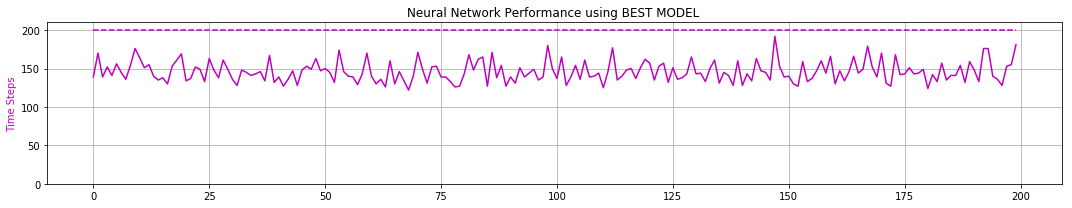

peak memory: 73749.31 MiB, increment: 65255.62 MiB
0 -max- [ 1.377  1.695  0.144  1.316  0.274]
0 -min- [-2.349 -2.613 -0.209 -1.350  0.225]

1 -max- [ 0.337  0.836  0.057  1.186  0.324]
1 -min- [-2.272 -2.570 -0.209 -1.352  0.276]

2 -max- [ 0.710  1.167  0.102  1.298  0.375]
2 -min- [-2.247 -2.418 -0.209 -1.355  0.327]

3 -max- [ 0.134  0.828  0.049  1.410  0.425]
3 -min- [-2.214 -2.530 -0.209 -1.662  0.375]

4 -max- [ 0.138  1.018  0.051  1.313  0.475]
4 -min- [-2.125 -2.423 -0.209 -1.350  0.426]

5 -max- [ 0.143  0.828  0.054  1.256  0.525]
5 -min- [-2.261 -2.565 -0.209 -1.354  0.475]

6 -max- [ 0.116  0.778  0.050  1.304  0.574]
6 -min- [-2.064 -2.422 -0.209 -1.418  0.525]

7 -max- [ 0.134  0.632  0.049  1.559  0.625]
7 -min- [-2.337 -2.603 -0.209 -1.373  0.575]

8 -max- [ 0.118  0.819  0.049  1.309  0.675]
8 -min- [-2.022 -2.411 -0.209 -1.423  0.625]

9 -max- [ 0.107  1.127  0.050  1.513  0.725]
9 -min- [-2.050 -2.425 -0.209 -1.652  0.675]

Quantization TIME:  0.59 minutes


ITER

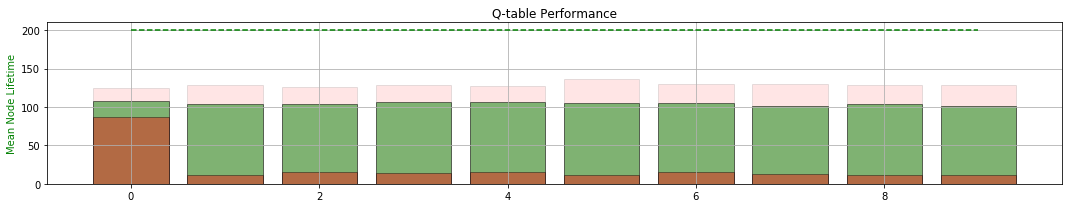

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 77.729	LOSS : 86.968	LOSS : 83.589	LOSS : 85.320	LOSS : 74.472	LOSS : 86.334	LOSS : 86.054	LOSS : 73.098	LOSS : 76.102	LOSS : 75.838	LOSS : 70.719	LOSS : 81.554	LOSS : 79.462	LOSS : 69.780	LOSS : 79.807	LOSS : 88.857	

In [ ]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [ ]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

In [ ]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [ ]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))